<a href="https://colab.research.google.com/github/RidmieWee/DS_Project/blob/main/3.%20Implementation/gaze_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.utils import to_categorical
from google.colab import drive

In [ ]:
# Mount into the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define data folder and classes
images = '../content/drive/MyDrive/Research/data_gaze'
categories = ['look_forward', 'look_left', 'look_right']

In [ ]:
# Define a array for stre images
data = []

# Define a function to extract data from folder
def extract_data():
    # Iterate over each folder in directory
    for category in categories:
        # Defie the path to directory
        path = os.path.join(images, category)
        # Extract the index
        class_num = categories.index(category)
        # Iterate over each imane
        for img in os.listdir(path):
            try:
                # Read image
                img_array = cv2.imread(os.path.join(path, img))
                # Add image and labelinto new array
                data.append([img_array, category])
            # Check for any errors to ignore
            except Exception as e:
                pass

In [ ]:
# Call function to extract data
extract_data()

In [ ]:
# Ensure the data length
print(len(data))

10121


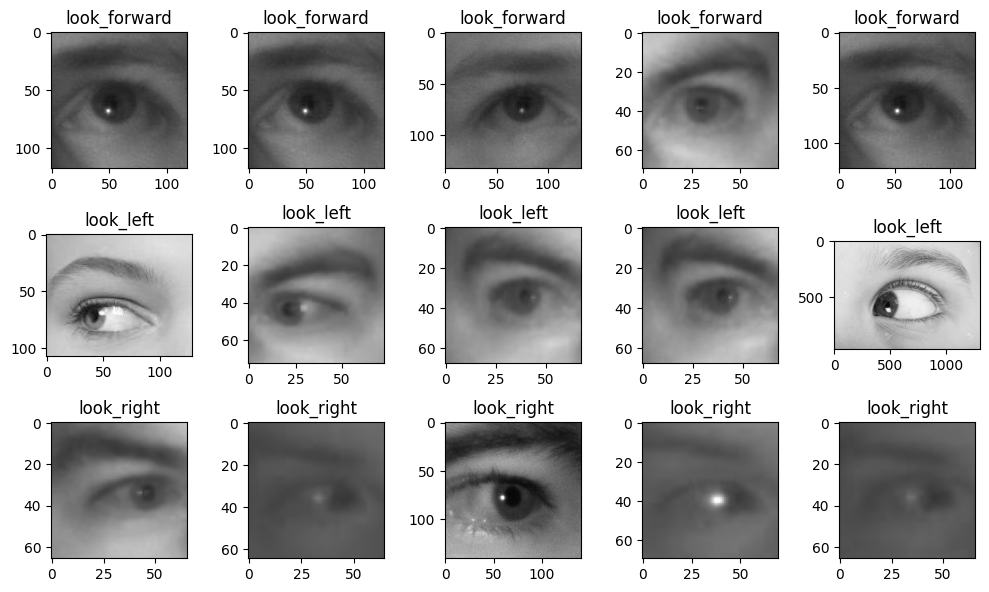

In [ ]:
# Explore extract images

# Define the number of rows and columns
rows = 3
columns = 5

# Define size for the figure
plt.figure(figsize=(10, 6))

# Iterate over each class
for class_name in categories:
    # Filter images of each class
    class_images = [img_data for img_data in data if img_data[1] == class_name]
    # Plot images of each class
    for i in range(min(len(class_images), 5)):
        plt.subplot(rows, columns, categories.index(class_name) * 5 + i + 1)
        plt.imshow(class_images[i][0])
        plt.title(class_name)
        plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Calculate image statistics

# Define a function to extract image statistics
def calculate_image_statistics(data):
    # Define dictionary to store statistics for each category
    statistics = {'look_forward': [], 'look_left': [], 'look_right': []}
    # Iterate over each image-category pair
    for image, category in data:
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Add mean pixel intensity
        statistics[category].append(np.mean(grayscale_image))
    # Return new dictionary
    return statistics

# Call function to calculate image statistics
image_statistics = calculate_image_statistics(data)

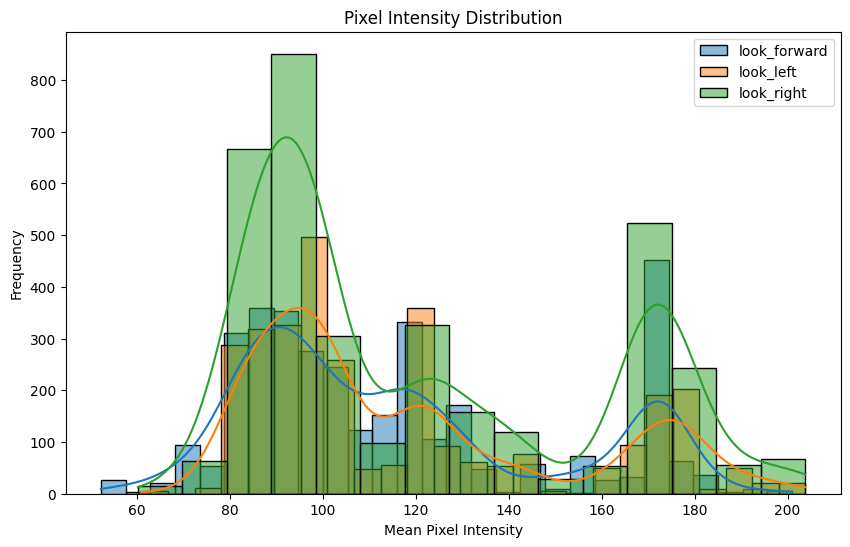

In [ ]:
# Plot histograms of pixel intensity distributions
# Define a figure
plt.figure(figsize=(10, 6))

# Iterte over each category
for category in categories:
    # Plot data points as a histogram
    sns.histplot(image_statistics[category], kde=True, label=category, alpha=0.5)

# Define labels for axies and title
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
# Add legend
plt.legend()

# Plot the graph
plt.show()

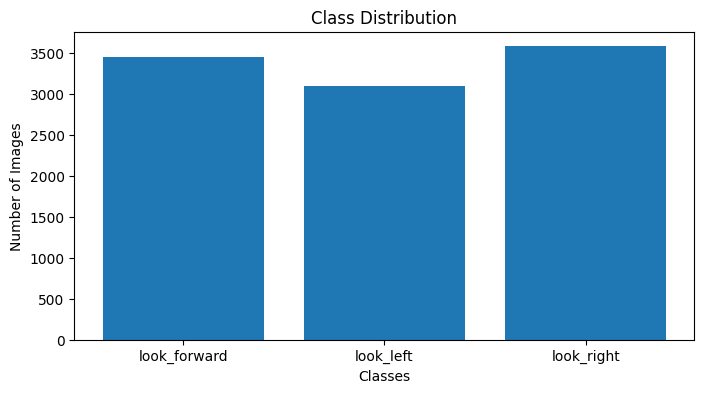

In [ ]:
# Identify class imbalance

# Define a figure
plt.figure(figsize=(8, 4))

# Calculate the total images
image_count = {category: len([img for img,
                              cat in data if cat == category])
                              for category in categories}

# Plot the count of each category
plt.bar(image_count.keys(), image_count.values())

# Define axis labels and titles
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')

# Show the plot
plt.show()

In [ ]:
# Check the shape of each image

# Iterate over each image
for image, category in data:

    # Check the shape
    image_shape = image.shape

    # Print the shape
    print(f"Image shape: {image_shape}, Category: {category}")

Streaming output truncated to the last 5000 lines.
Image shape: (71, 71, 3), Category: look_left
Image shape: (77, 77, 3), Category: look_left
Image shape: (80, 80, 3), Category: look_left
Image shape: (88, 88, 3), Category: look_left
Image shape: (108, 108, 3), Category: look_left
Image shape: (82, 82, 3), Category: look_left
Image shape: (72, 72, 3), Category: look_left
Image shape: (77, 77, 3), Category: look_left
Image shape: (84, 84, 3), Category: look_left
Image shape: (79, 79, 3), Category: look_left
Image shape: (111, 111, 3), Category: look_left
Image shape: (73, 73, 3), Category: look_left
Image shape: (71, 71, 3), Category: look_left
Image shape: (73, 73, 3), Category: look_left
Image shape: (78, 78, 3), Category: look_left
Image shape: (108, 108, 3), Category: look_left
Image shape: (82, 82, 3), Category: look_left
Image shape: (85, 85, 3), Category: look_left
Image shape: (81, 81, 3), Category: look_left
Image shape: (85, 85, 3), Category: look_left
Image shape: (72, 72, 3

In [ ]:
# Define the newsize
new_size = (64, 64)

# Iterate over each image
for i in range(len(data)):

    # Extract image and category
    image, category = data[i]

    # Resize the image
    resized_image = cv2.resize(image, new_size)

    # Add the image with new size
    data[i] = (resized_image, category)

In [ ]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64, 3)


In [ ]:
# Iterate over each image
for i in range(len(data)):
    # Extract the images and label
    img_array, category = data[i]

    # Convert it into grayscale
    grayscale_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Update the data list with the grayscale image
    data[i] = [grayscale_img, category]


In [69]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64)


In [70]:
# Construct random data

# Shuffling the data
random.shuffle(data)

In [90]:
# Define lists data images and labels
X = []
y = []

# Iterate over each image
for features, label in data:

    # Add images into the list
    X.append(features)
    # Add labels into the list
    y.append(label)

# Convert into a numpy array
X = np.array(X)
Y = np.array(y)

In [91]:
# Explore the shape of image list
X.shape

(10121, 64, 64)

In [92]:
# Expanding 2D dimension into 3D
X = np.expand_dims(X,-1)

In [93]:
# Splitting data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [94]:
# Explore shape
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6781, 64, 64, 1) (6781,) (3340, 64, 64, 1) (3340,)


In [95]:
# Normalizing the images using min-max scaling

# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Reduce pixel values
x_train /= 255
x_test /= 255

In [96]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [97]:
# One-hot encode the integer labels
y_train_onehot = to_categorical(y_train_encoded, num_classes=3)
y_test_onehot = to_categorical(y_test_encoded, num_classes=3)

In [98]:
# Explore shape
print(x_train.shape, y_train_onehot.shape, x_test.shape, y_test_onehot.shape)

(6781, 64, 64, 1) (6781, 3) (3340, 64, 64, 1) (3340, 3)


In [99]:
# Define data augmentation
train_generator = ImageDataGenerator(
    # Randomly rotate image
    rotation_range=20,
    # Defime zoom range
    zoom_range=0.15,
    # Randomly shift images horizontally
    width_shift_range=0.2,
    # Randomly shift images vertically
    height_shift_range=0.2,
    # Define random shear
    shear_range=0.15,
    # Define flip image
    horizontal_flip=True,
    # Define mode for filling points
    fill_mode="nearest")

In [103]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# First convolutional block
conv1 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal')(input_layer)
conv2 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal')(conv1)
batch_norm1 = BatchNormalization()(conv2)
max_pool1 = MaxPooling2D(3)(batch_norm1)

# Second convolutional block
conv3 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal')(max_pool1)
batch_norm2 = BatchNormalization()(conv3)
max_pool2 = MaxPooling2D(3)(batch_norm2)

# Third convolutional block
conv4 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal')(max_pool2)
batch_norm3 = BatchNormalization()(conv4)
max_pool3 = MaxPooling2D(3)(batch_norm3)

# Flatten layer
flatten = Flatten()(max_pool3)

# Fully connected layers
dense1 = Dense(64, activation='relu', kernel_initializer='he_normal')(flatten)
batch_norm4 = BatchNormalization()(dense1)
output_layer = Dense(3, activation='softmax', kernel_initializer='glorot_normal')(batch_norm4)

# Create model
model_v2 = Model(inputs=input_layer, outputs=output_layer)

In [104]:
# Compiling the model
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
# Define the path to save the model
path = '../content/drive/MyDrive/Research/Saved_models/Gaze_detection'

# Ensure the directory exists
os.makedirs(path, exist_ok=True)

# Define the path to save the model
model_checkpoint_path2 = os.path.join(path, 'bestModel_v2.h5')

In [106]:
callback = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path2,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [107]:
# Train the model
history2 = model_v2.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
170/170 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8864
Epoch 1: val_loss improved from inf to 0.91896, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_v2.h5
170/170 [==============================] - 33s 181ms/step - loss: 0.3242 - accuracy: 0.8864 - val_loss: 0.9190 - val_accuracy: 0.5402
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9484
Epoch 2: val_loss improved from 0.91896 to 0.48293, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_v2.h5
170/170 [==============================] - 31s 180ms/step - loss: 0.1628 - accuracy: 0.9484 - val_loss: 0.4829 - val_accuracy: 0.7789
Epoch 3/30
170/170 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9581
Epoch 3: val_loss improved from 0.48293 to 0.40493, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_v2.h5
170/170 [==============================] - 31s 182ms/step - loss: 0.1396 - accuracy: 0.9581 - val_loss: 0.4049 - val_accuracy: 0.8342
Epoch 4/30
170/170 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9676
Epoch 4: val_loss improved from 0.40493 to 0.16608, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_v2.h5
170/170 [========

In [109]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_v2 = model_v2.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_v2[0])
print('Test accuracy:', test_loss_accuracy_v2[1])

105/105 [==============================] - 5s 45ms/step - loss: 0.3482 - accuracy: 0.9368
Test loss: 0.34816181659698486
Test accuracy: 0.9368263483047485


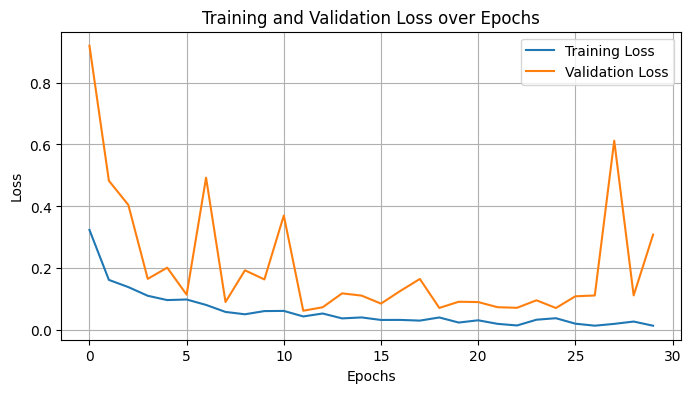

In [110]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

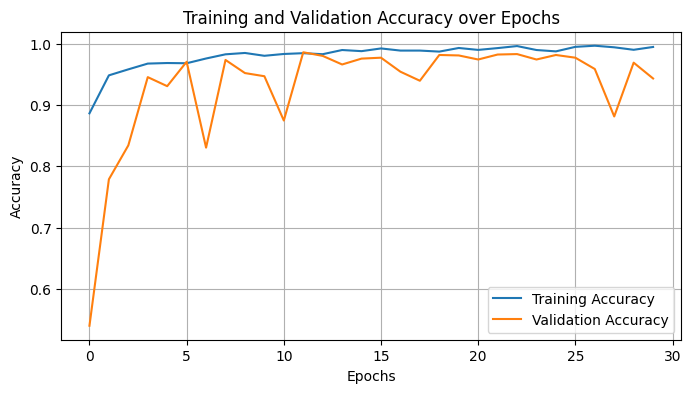

In [111]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [112]:
# Save the entire model
model_v2.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/model_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [113]:
# Load best model performance
best_model_v2 = load_model('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_v2.h5')

# Evaluate model performance
best_model_v2.evaluate(x_test, y_test_onehot)

105/105 [==============================] - 4s 40ms/step - loss: 0.0861 - accuracy: 0.9775


[0.08605067431926727, 0.977544903755188]

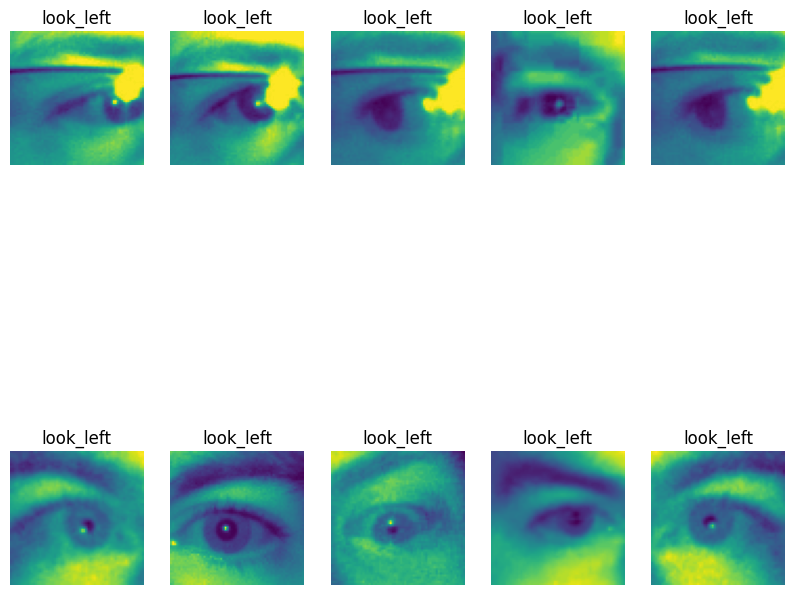

In [115]:
import matplotlib.pyplot as plt

# Define the classes
classes = ['look_forward', 'look_right', 'look_left']

# Plot the predicted data
plt.figure(figsize=(10, 10))
for i in range(10):  # Assuming you want to plot the first 10 predictions
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])  # Assuming x_test contains the test images
    predicted_class = classes[np.argmax(predictions[i])]  # predictions contains the predicted probabilities
    plt.title(predicted_class)
    plt.axis('off')

plt.show()


In [116]:
# Predict labels for test data
y_pred_onehot = model_v2.predict(x_test)

# Convert one-hot encoded predictions back to categorical labels
y_pred_encoded = np.argmax(y_pred_onehot, axis=1)

# Decode categorical labels back to original string labels
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# Convert test labels back to original string labels
y_test_labels = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))

# Show predicted data with labels
for i in range(len(y_pred_labels)):
    print("Predicted Label: {}, Actual Label: {}".format(y_pred_labels[i], y_test_labels[i]))


105/105 [==============================] - 5s 47ms/step
Predicted Label: look_right, Actual Label: look_right
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_left, Actual Label: look_left
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_left, Actual Label: look_left
Predicted Label: look_right, Actual Label: look_right
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_left, Actual Label: look_left
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_right, Actual Label: look_right
Predicted Label: look_right, Actual Label: look_right
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_left, Actual Label: look_left
Predicted Label: look_forward, Actual Label: look_forward
Predicted Label: look_left, Actual Label: look_left
Pred

105/105 [==============================] - 5s 48ms/step


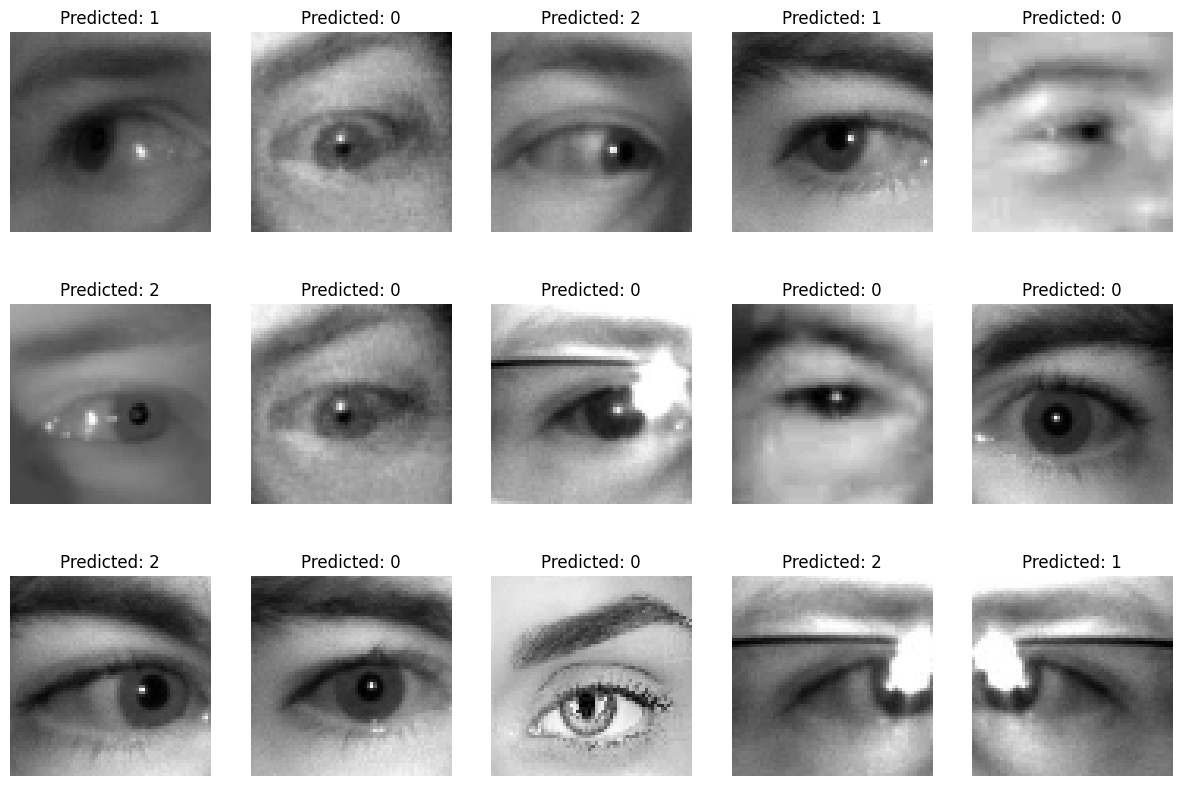

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Predict labels for test images
predicted_labels_onehot = model_v2.predict(x_test)
predicted_labels = np.argmax(predicted_labels_onehot, axis=1)

# Select 15 random indices from the test set
random_indices = np.random.choice(x_test.shape[0], 15, replace=False)

# Plot the images along with predicted labels
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[index]}")
    plt.axis('off')

plt.show()


105/105 [==============================] - 5s 47ms/step


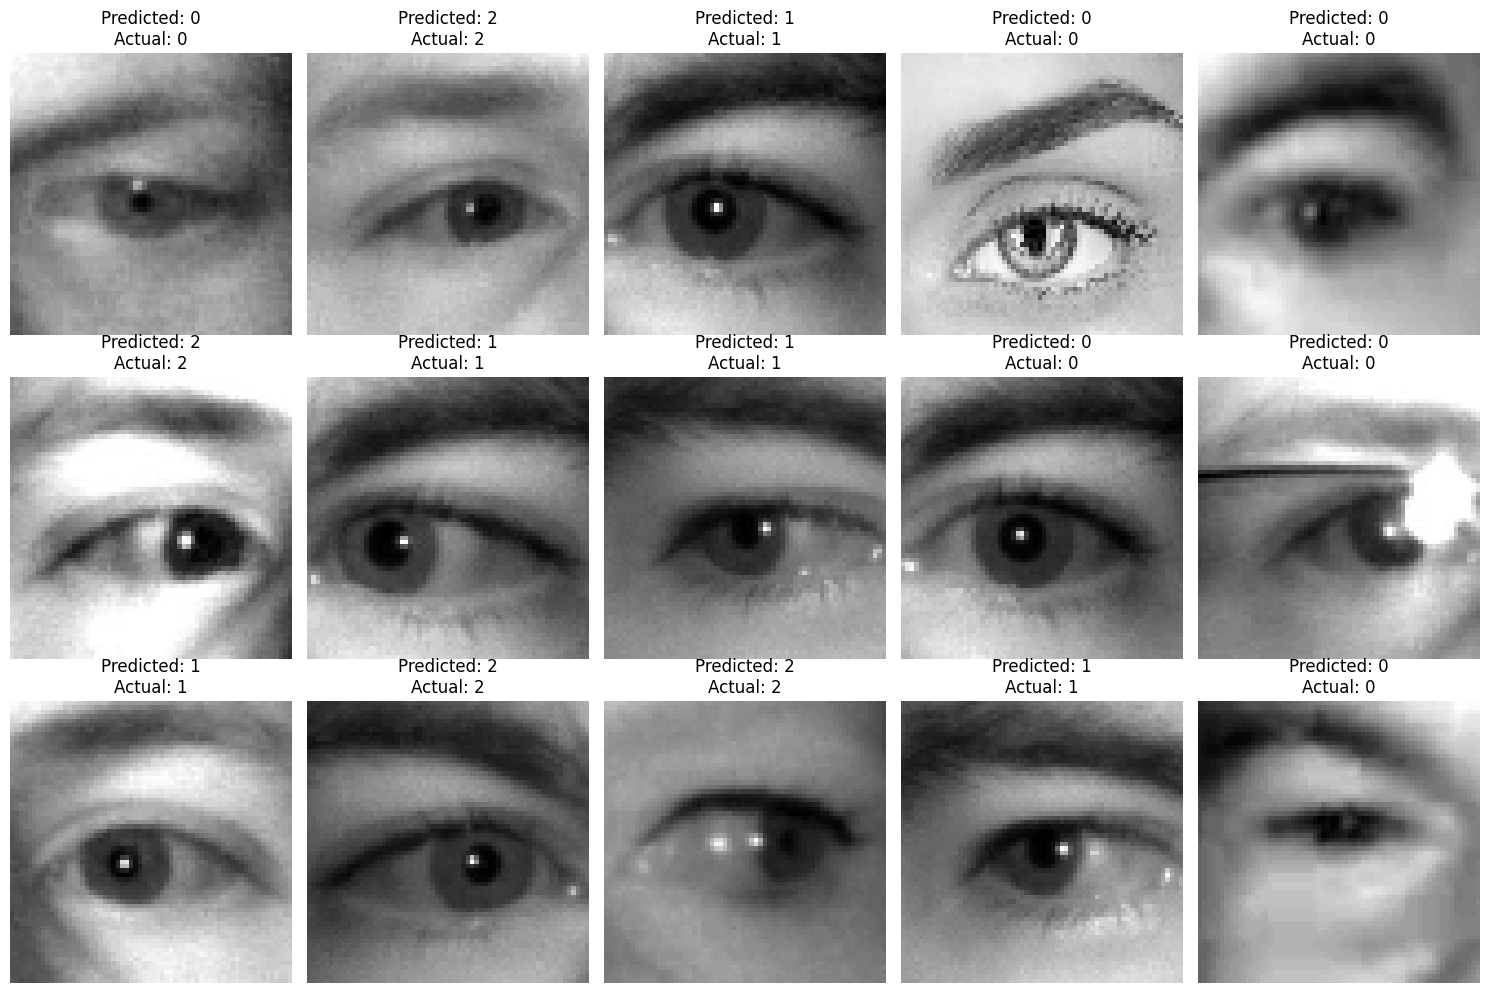

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Predict labels for test images
predicted_labels = np.argmax(model_v2.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[index]}\nActual: {np.argmax(y_test_onehot[index])}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 6s 54ms/step


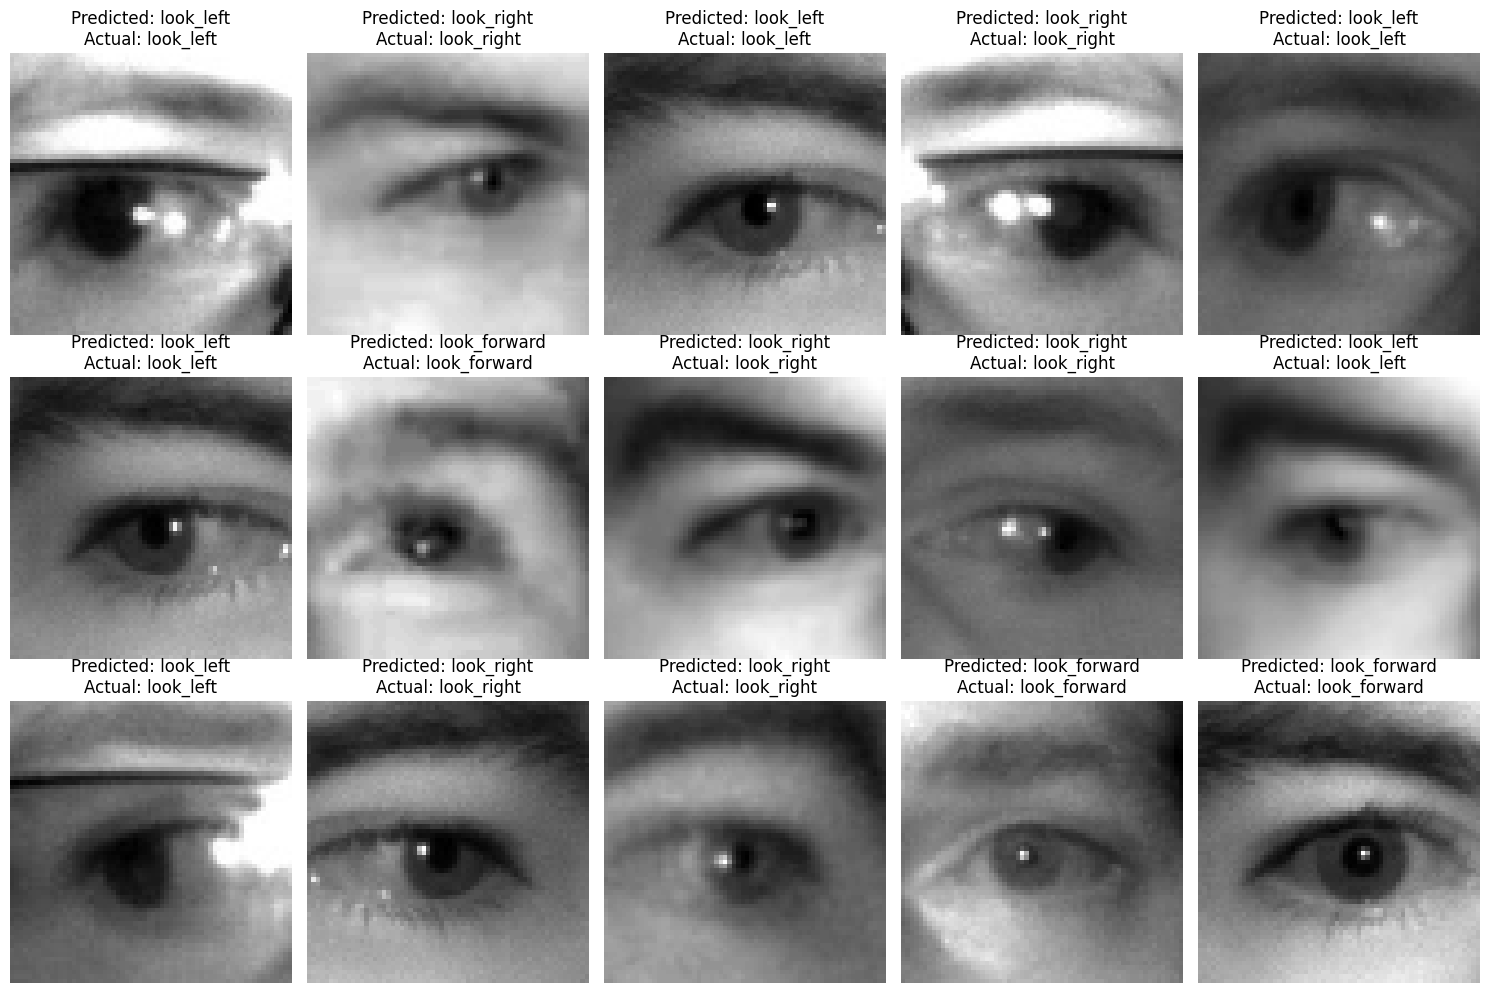

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(model_v2.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [120]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(model_v2.predict(x_test), axis=1)
# Convert one-hot encoded test labels back to integers
y_test_int = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_int, predicted_labels)

# Calculate classification report
class_report = classification_report(y_test_int, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


105/105 [==============================] - 6s 55ms/step
Confusion Matrix:
[[1111    0    3]
 [  77  962    9]
 [ 122    0 1056]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1114
           1       1.00      0.92      0.96      1048
           2       0.99      0.90      0.94      1178

    accuracy                           0.94      3340
   macro avg       0.95      0.94      0.94      3340
weighted avg       0.95      0.94      0.94      3340



105/105 [==============================] - 5s 44ms/step


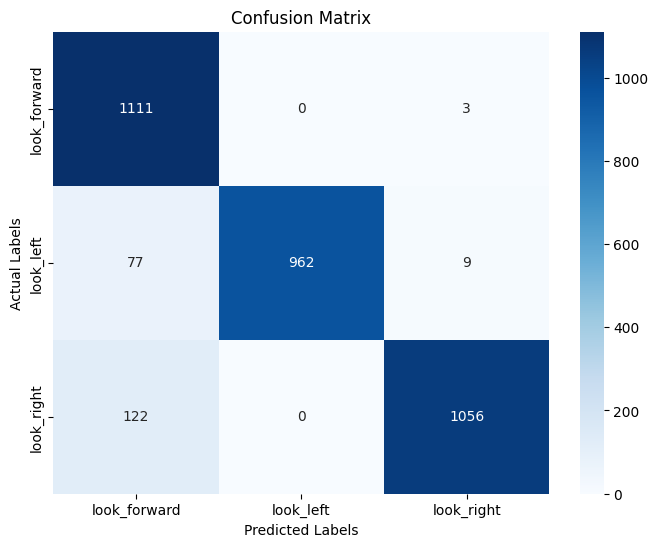

Classification Report:
               precision    recall  f1-score   support

look_forward       0.85      1.00      0.92      1114
   look_left       1.00      0.92      0.96      1048
  look_right       0.99      0.90      0.94      1178

    accuracy                           0.94      3340
   macro avg       0.95      0.94      0.94      3340
weighted avg       0.95      0.94      0.94      3340



In [121]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(model_v2.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)
